In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()
# reflect the tables
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Get a list of column names and types in the table "station"
Station_columns = inspector.get_columns('station')
for c in Station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Get a list of column names and types in the table "measurement"
Measurement_columns = inspector.get_columns('measurement')
for c in Measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Find the most recent date in the data set.
session.query(func.count(Measurement.date)).all()
# The most recent Date
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date[0]

'2017-08-23'

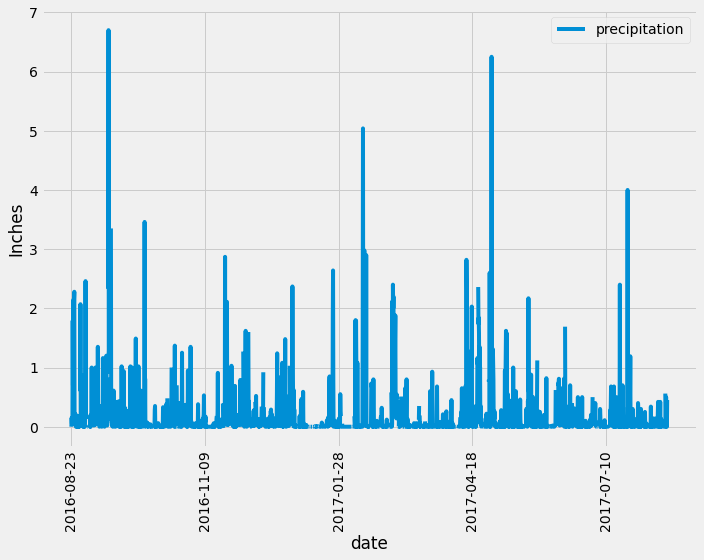

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_year = dt.date.fromisoformat(most_recent_date[0]).strftime("%Y")
most_recent_month = dt.date.fromisoformat(most_recent_date[0]).strftime("%m")
most_recent_day = dt.date.fromisoformat(most_recent_date[0]).strftime("%d")
# Calculate the date one year from the last date in data set.
previous_year = int(most_recent_year)-1
previous_year_date = dt.date(previous_year, int(most_recent_month), int(most_recent_day))
# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= previous_year_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns=['date', 'precipitation'])
df = df.set_index('date')
# Sort the dataframe by date
df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax= df.plot(figsize=(10,8),rot=90)
ax.set_ylabel("Inches")
plt.tight_layout()
plt.savefig('Images/precipitation.png', dpi=150)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.aggregate(['mean', 'median','var','std', 'sem'])

,precipitation
mean,0.177279
median,0.020000
var,0.212696
std,0.461190
sem,0.010259


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
total_measurement = session.query(Measurement.station).group_by(Measurement.station).count()
total_measurement

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
total_measurement = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
total_measurement

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = total_measurement[0][0]
lowest =session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
highest =session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()
average =session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active).all()

print(f"The lowest temperature at the most active station was {lowest[0][0]} degrees.")
print(f"The highest temperature at the most active station was {highest[0][0]} degrees.")
print(f"The average temperature at the most active station was {average[0][0]} degrees.")


The lowest temperature at the most active station was 54.0 degrees.
The highest temperature at the most active station was 85.0 degrees.
The average temperature at the most active station was 71.66378066378067 degrees.


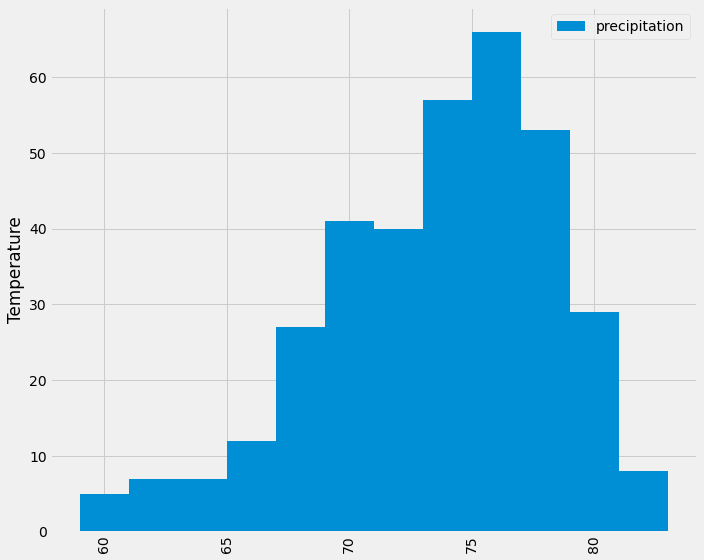

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= previous_year_date, Measurement.station == most_active).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data, columns=['date', 'precipitation'])
df = df.set_index('date')
# Sort the dataframe by date
df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax= df.plot(kind="hist", figsize=(10,8),rot=90, bins=12)
ax.set_ylabel("Temperature")
plt.tight_layout()
plt.savefig('Images/station-histogram.png', dpi=150)
plt.show()

# Close session

In [19]:
# Close Session
session.close()